policy iteration
Loading tables...
Total runtime for policy iteration: 0:00:00.131849
Policy saved.
Values saved.


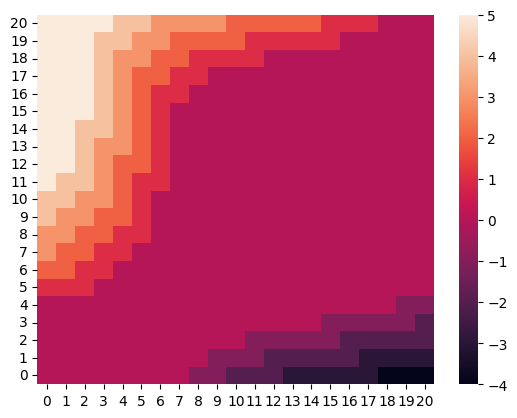

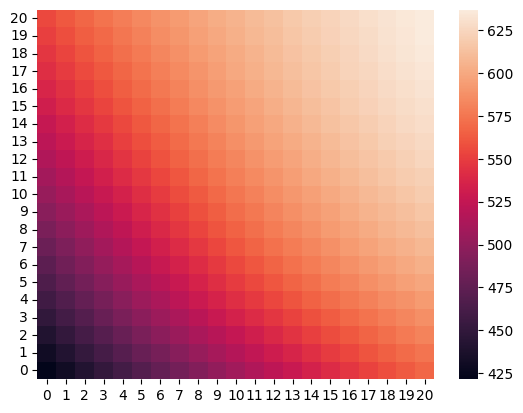

In [1]:
"""Dynamic programming solution to the Jack's Car Rental problem"""
from math import factorial, exp
from datetime import datetime
from itertools import product
from sys import argv
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

GAMMA = 0.9
MAX_CARS = 20
MS = MAX_CARS + 1
MM = 5
D_MIN = 0.01
LAMBDAS = [2, 3, 4]
MOD = ""
METHOD = "policy iteration"


def poisson(lmbd, number_n):
    """Returns the value of the poisson distribution for lambda, n"""
    return ((lmbd**number_n) / factorial(number_n)) * exp(-lmbd)


def post_return_prob(s_pret, s_preq, poissons):
    """Returns the probability of reaching s_pret cars after customers
    return cars in the state that already has s_preq cars."""
    d_first = s_pret[0]-s_preq[0]
    if s_pret[0] == MAX_CARS:
        if d_first == 0:
            p_first = 1
        else:
            p_first = 1 - sum(poissons["3"][i] for i in range(d_first))
    else:
        p_first = poissons["3"][d_first]
    d_second = s_pret[1]-s_preq[1]
    if s_pret[1] == MAX_CARS:
        if d_second == 0:
            p_second = 1
        else:
            p_second = 1 - sum(poissons["2"][i] for i in range(d_second))
    else:
        p_second = poissons["2"][d_second]
    probability = p_first * p_second
    return probability


def post_request_prob(s_preq, s_pa, poissons):
    """Returns the probability of reaching s_preq cars after customers
    request cars in the state that already has s_pa cars."""
    d_first = s_pa[0]-s_preq[0]
    if s_preq[0] == 0:
        if d_first == 0:
            p_first = 1
        else:
            p_first = 1 - sum(poissons["3"][i] for i in range(d_first))
    else:
        p_first = poissons["3"][d_first]
    d_second = s_pa[1]-s_preq[1]
    if s_preq[1] == 0:
        if d_second == 0:
            p_second = 1
        else:
            p_second = 1 - sum(poissons["4"][i] for i in range(d_second))
    else:
        p_second = poissons["4"][d_second]
    probability = p_first * p_second
    return probability


def get_reward(s_preq, s_pa):
    """Calculates the reward for a state transition from s_pa to s_preq"""
    r_0 = 10 * (s_pa[0] - s_preq[0])
    r_1 = 10 * (s_pa[1] - s_preq[1])
    return r_0 + r_1


def p_4(s_pret, s_preq, s_pa, poissons):
    """Returns the value of the general probability distribution P(s',r|s,a)"""
    preq = post_request_prob(s_preq, s_pa, poissons)
    pret = post_return_prob(s_pret, s_preq, poissons)
    return preq*pret


def initialize_problem():
    """Returns the initialized problem"""
    values = np.zeros((MS, MS), dtype=np.float64)
    policy = np.zeros((MS, MS), dtype=int)
    actions = np.zeros((MS, MS), dtype=object)
    for n_1, n_2 in product(range(MS), range(MS)):
        actions[n_1, n_2] = list(range(-min(MM, MAX_CARS-n_1, n_2),
                                 min(MM, MAX_CARS-n_2, n_1)+1))
    return values, policy, actions


def initialize_tables():
    """Returns the precalculated probabilities and rewards"""
    print("Building tables...")
    poissons = {str(lmbd): [poisson(lmbd, n) for n in range(MS)]
                for lmbd in LAMBDAS}
    s_prets = np.zeros((MS,), dtype=object)
    s_preqs = np.zeros((MS,), dtype=object)
    for bound in range(MS):
        s_prets[bound] = list(range(bound, MS))
        s_preqs[bound] = list(range(bound+1))

    probs = np.zeros((MS, MS, MS, MS))
    rewards = np.zeros((MS, MS))
    for n_1, n_2 in product(range(MS), range(MS)):
        print(f"State: [{n_1}, {n_2}]  ", end='\r')
        rewards[n_1, n_2] = 0
        for preq1, preq2 in product(s_preqs[n_1], s_preqs[n_2]):
            p_preq = post_request_prob([preq1, preq2], [n_1, n_2], poissons)
            rewards[n_1, n_2] += p_preq * get_reward([preq1, preq2],
                                                     [n_1, n_2])
            for pret1, pret2 in product(s_prets[preq1], s_prets[preq2]):
                p_pret = post_return_prob([pret1, pret2], [preq1, preq2],
                                          poissons)
                probs[n_1, n_2, pret1, pret2] += p_pret * p_preq
    return probs, rewards


def get_value(state, action, values, probs, rewards):
    """Returns the expected return of a (state, action) pair"""
    state_1, state_2 = state
    aprobs = probs[state_1, state_2, :, :]
    reward = rewards[state_1, state_2] - 2 * abs(action)
    return reward + GAMMA * (values * aprobs).sum()


def get_alternate_value(state, action, values, probs, rewards):
    """Returns the expected return of a (state, action) pair

    This version is for the modified problem."""
    state_1, state_2 = state
    aprobs = probs[state_1, state_2, :, :]
    if action > 0:
        mv_cost = 2 * (action - 1)
    else:
        mv_cost = -2 * action
    reward = rewards[state_1, state_2] - mv_cost
    return reward + GAMMA * (values * aprobs).sum()


def evaluate_policy_iteration(policy, values, probs, rewards):
    """Returns the optimal value function for every (state, action) pair
    following a given policy"""
    while True:
        d_max = 0
        for state_1, state_2 in product(range(MS), range(MS)):
            action = policy[state_1, state_2]
            old_value = values[state_1, state_2]
            sa_value = value_function([state_1-action, state_2+action],
                                      action, values, probs, rewards)
            values[state_1, state_2] = sa_value
            d_max = max(d_max, abs(old_value-values[state_1, state_2]))
        if d_max < D_MIN:
            return values


def improve_policy_iteration(policy, actions, values, probs, rewards):
    """Returns the greedy policy with respect to the given value function"""
    done = True
    for state_1, state_2 in product(range(MS), range(MS)):
        old_value = values[state_1, state_2]
        old_action = policy[state_1, state_2]
        best_action = policy[state_1, state_2]
        for action in actions[state_1, state_2]:
            new_value = value_function([state_1-action, state_2+action],
                                       action, values, probs, rewards)
            if new_value > old_value:
                old_value = new_value
                best_action = action
        if best_action != old_action:
            policy[state_1, state_2] = best_action
            done = False
    return policy, done


def evaluate_value_iteration(values, actions, probs, rewards):
    """Returns the optimal value function for every state"""
    while True:
        d_max = 0
        for state_1, state_2 in product(range(MS), range(MS)):
            old_value = values[state_1, state_2]
            sa_values = [value_function([state_1-action, state_2+action],
                                        action, values, probs, rewards)
                         for action in actions[state_1, state_2]]
            values[state_1, state_2] = max(sa_values)
            d_max = max(d_max, abs(old_value-values[state_1, state_2]))
        print(f"delta: {d_max:.9f}\t", end='\r')
        if d_max < D_MIN:
            return values


def improve_value_iteration(policy, actions, values, probs, rewards):
    """Returns the greedy policy with respect to the given value function"""
    for state_1, state_2 in product(range(MS), range(MS)):
        print(f"Finding best action for state [{state_1}, {state_2}]  ",
              end='\r')
        state_action_values = [(action,
                                value_function(
                                    [state_1-action, state_2+action],
                                    action, values, probs, rewards))
                               for action in actions[state_1, state_2]]
        policy[state_1, state_2] = max(state_action_values,
                                       key=lambda x: x[1])[0]
    print()
    return policy


def evaluate_gpi(values, policy, actions, probs, rewards):
    """Returns the optimal value function, and policy, for every state"""
    while True:
        d_max = 0
        for state_1, state_2 in product(range(MS), range(MS)):
            old_value = values[state_1, state_2]
            best_value = values[state_1, state_2]
            best_action = policy[state_1, state_2]
            for action in actions[state_1, state_2]:
                value = value_function([state_1-action, state_2+action],
                                       action, values, probs, rewards)
                if value > best_value:
                    best_value = value
                    best_action = action
            policy[state_1, state_2] = best_action
            values[state_1, state_2] = best_value
            d_max = max(d_max, abs(old_value-values[state_1, state_2]))
        print(f"delta: {d_max:.9f}\t", end='\r')
        if d_max < D_MIN:
            return values, policy


value_function = get_value
if len(argv) > 2 and argv[2] == "--modified":
    value_function = get_alternate_value
    MOD = "_modified"


if __name__ == "__main__":
    print(METHOD)
    current_values, current_policy, action_set = initialize_problem()
    try:
        with open(f"./tables/{MS}_{MM}_tables.json") as tables_file:
            print("Loading tables...")
            tables = json.load(tables_file)
        probabilities = np.array(tables["probabilities"])
        transition_rewards = np.array(tables["transition_rewards"])
    except FileNotFoundError:
        probabilities, transition_rewards = initialize_tables()
        tables = {
            "probabilities": probabilities.tolist(),
            "transition_rewards": transition_rewards.tolist()
        }
        with open(f"./tables/{MS}_{MM}_tables.json", "w") as tables_file:
            json.dump(tables, tables_file)

    if METHOD == "policy iteration":
        start = datetime.now()
        DONE = False
        while not DONE:
            current_values = evaluate_policy_iteration(current_policy,
                                                       current_values,
                                                       probabilities,
                                                       transition_rewards)
            current_policy, DONE = improve_policy_iteration(current_policy,
                                                            action_set,
                                                            current_values,
                                                            probabilities,
                                                            transition_rewards)
    elif METHOD == "value iteration":
        start = datetime.now()
        current_values = evaluate_value_iteration(current_values,
                                                  action_set,
                                                  probabilities,
                                                  transition_rewards)
        print("Value iteration complete!")
        current_policy = improve_value_iteration(current_policy, action_set,
                                                 current_values, probabilities,
                                                 transition_rewards)
        print("Policy updated.")
    elif METHOD == "gpi":
        start = datetime.now()
        current_values, current_policy = evaluate_gpi(current_values,
                                                      current_policy,
                                                      action_set,
                                                      probabilities,
                                                      transition_rewards)
        print("\nGPI complete!")
    else:
        raise Exception("Unknown procedure provided!")
    runtime = datetime.now() - start
    print(f"Total runtime for {METHOD}: {runtime}")

    with open(f"./results/{argv[1]}_policy{MOD}_{MS}_{MM}.json",
              "w") as policy_file:
        policy_json = {
            f"{state_1}, {state_2}": int(current_policy[state_1, state_2])
            for state_1, state_2 in product(range(MS), range(MS))
        }
        json.dump(policy_json, policy_file, indent=4)
    print("Policy saved.")
    with open(f"./results/{argv[1]}_value{MOD}_{MS}_{MM}.json",
              "w") as value_file:
        values_json = {
            f"{state_1}, {state_2}": float(current_values[state_1, state_2])
            for state_1, state_2 in product(range(MS), range(MS))
        }
        json.dump(values_json, value_file, indent=4)
    print("Values saved.")

    plt.ylim(reversed(plt.ylim()))
    sns.heatmap(current_policy).invert_yaxis()
    plt.show()
    sns.heatmap(current_values).invert_yaxis()
    plt.show()
